In [198]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [199]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [200]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400


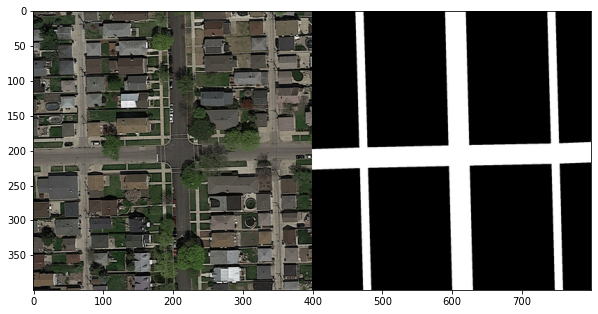

In [201]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [202]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [203]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [204]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [205]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 6250 features
Feature dimension = 2
Number of classes = 1
Class 0: 4422 samples
Class 1: 1828 samples


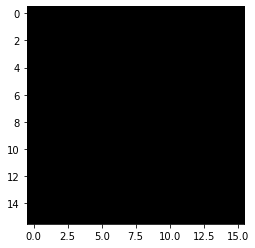

In [206]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

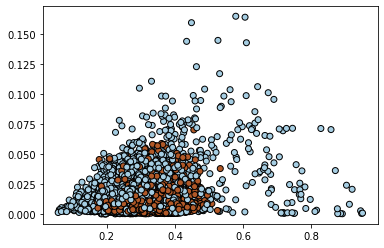

In [207]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [208]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced')

In [209]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.19296


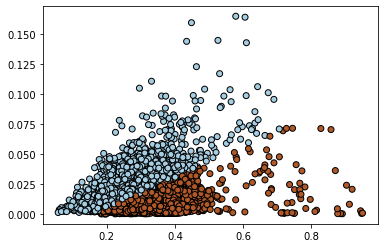

In [210]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [211]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

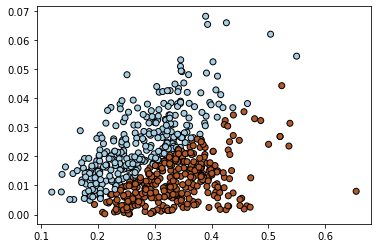

In [212]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

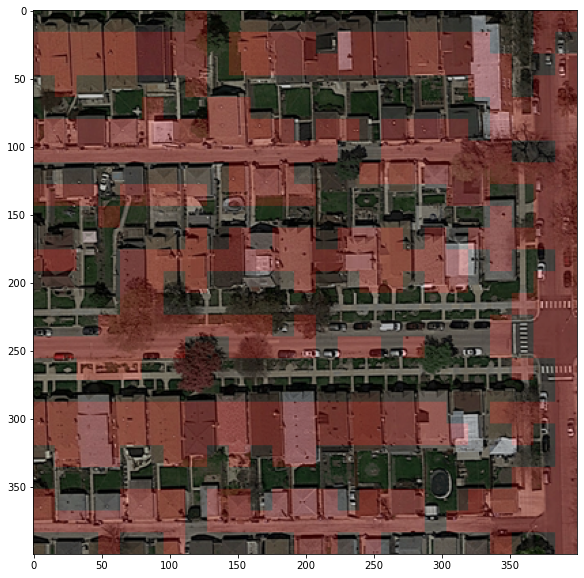

In [213]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)


## KNN

#### Optimal hyerparameter for KNN

In [214]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#### choosing an optimal k in KNN using cross-validation
sqrt_n = int(np.sqrt(X.shape[0]))
# Optimal k is usually about the square root of n
k_range = range(sqrt_n - 25, sqrt_n + 20, 2)
# Selecting the best k using cross-validation
f1_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=5, scoring="f1")
    f1_scores.append(scores.mean())

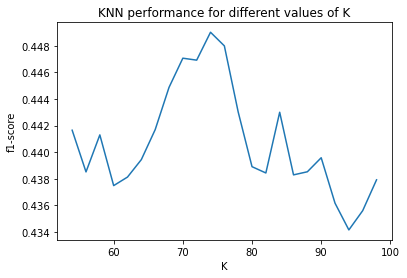

In [215]:
#### Plotting f1-score for each value of K studied
plt.plot(k_range, f1_scores)
plt.xlabel("K")
plt.ylabel("f1-score")
plt.title("KNN performance for different values of K")
plt.show()

In [216]:
# Best value for K in K-NN
K_optimal = k_range[f1_scores.index(max(f1_scores))]
print("Best value for K: {}".format(K_optimal))

Best value for K: 74


#### Testing KNN on one image 

True positive rate = 0.0576


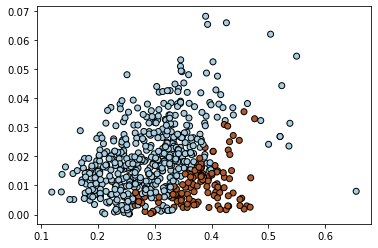

In [217]:
# Loading test image
img_idx = 12
Xi = extract_img_features(image_dir + files[img_idx])

# Training an all the other images of the dataset
knn_optimal = KNeighborsClassifier(n_neighbors=K_optimal)
knn_optimal.fit(X, Y)

# Running Prediction for the test image
Zi = knn_optimal.predict(Xi)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Zi)[0]
Yn = np.nonzero(Y)[0]
TPR = len(list(set(Yn) & set(Zn))) / float(len(Zi))
print('True positive rate = ' + str(TPR))

# Plot features using predictions to color datapoints
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

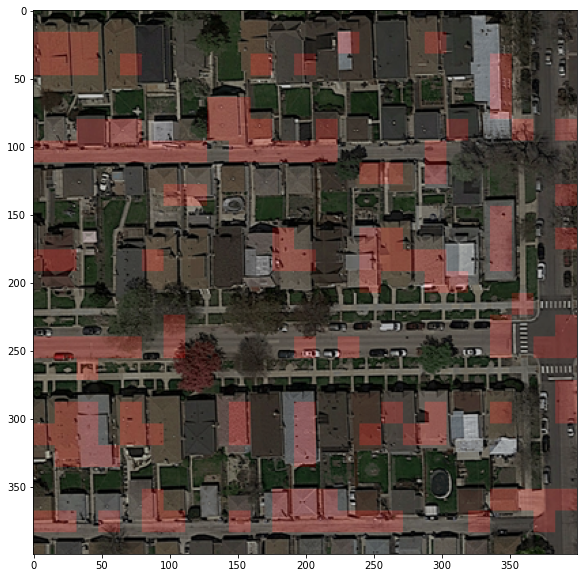

In [218]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

## CNN

In [247]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Loading the train set of image patches

In [248]:
# defining dataset class
from torch.utils.data import Dataset, DataLoader

class TrainingDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        # putting the channel dimension in second position (PyTorch convention)
        self.x = self.x.permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0] # Number of image patches in the dataset

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

In [249]:
# Loading the train set of image patches and their respective labels
trainset = TrainingDataset(img_patches, Y)
trainloader = DataLoader(trainset)

print("Number of patches in the training dataset: {}".format(trainloader.__len__()))

Number of patches in the training dataset: 6250


#### Defining the CNN for road segmentation

In [250]:
class NetSegmentation(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 16, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(24, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

#### Training the Network

In [251]:
# Creating an instance of CNN for road segmentation
seed = 42
np.random.seed(seed)
net = NetSegmentation()

In [277]:
# hyper parameters

# SGD tuning parameters
learning_rate = 0.001
momentum = 0.9
# Number of iteration over the training dataset
epochs = 2
# Threshold on the predicted probability to assign an image patch to one or the other class
threshold_decision = 0.5

In [253]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [288]:
# loop over the dataset multiple times
losses = []

for epoch in range(epochs):

    running_loss = 0.0
    for i, (x_train, y_train) in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(x_train)
        loss = criterion(output, y_train.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49: # print every 50 mini-batches
            avg_loss = running_loss / 50
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, avg_loss))
            losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.420
[1,   100] loss: 0.366
[1,   150] loss: 0.756
[1,   200] loss: 0.361
[1,   250] loss: 0.405
[1,   300] loss: 0.291
[1,   350] loss: 1.169
[1,   400] loss: 0.593
[1,   450] loss: 0.462
[1,   500] loss: 0.473
[1,   550] loss: 0.741
[1,   600] loss: 0.563
[1,   650] loss: 0.467
[1,   700] loss: 0.383
[1,   750] loss: 0.387
[1,   800] loss: 0.895
[1,   850] loss: 0.824
[1,   900] loss: 0.481
[1,   950] loss: 0.494
[1,  1000] loss: 0.481
[1,  1050] loss: 0.678
[1,  1100] loss: 0.377
[1,  1150] loss: 0.414
[1,  1200] loss: 0.379
[1,  1250] loss: 1.264
[1,  1300] loss: 0.997
[1,  1350] loss: 0.473
[1,  1400] loss: 0.388
[1,  1450] loss: 0.327
[1,  1500] loss: 0.516
[1,  1550] loss: 0.587
[1,  1600] loss: 0.464
[1,  1650] loss: 0.401
[1,  1700] loss: 0.443
[1,  1750] loss: 1.120
[1,  1800] loss: 0.655
[1,  1850] loss: 0.519
[1,  1900] loss: 0.484
[1,  1950] loss: 0.439
[1,  2000] loss: 0.402
[1,  2050] loss: 0.386
[1,  2100] loss: 0.815
[1,  2150] loss: 0.374
[1,  2200] 

#### Testing the Network on one image

In [289]:
# Loading test image
img_path = image_dir + files[12]
img_test = load_image(img_path)

# Test set of image patches
patches_test = img_crop(img_test, patch_size, patch_size)
Xi = torch.tensor(patches_test, dtype=torch.float32)
Xi = Xi.permute(0, 3, 1, 2)

# Running Prediction for the test image
probas = net(Xi).squeeze()
Zi = (probas >= threshold_decision).int()

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Zi)[0]
Yn = np.nonzero(Y)[0]
TPR = len(list(set(Yn) & set(Zn))) / float(len(Zi))
print('True positive rate = ' + str(TPR))

# Plot features using predictions to color datapoints
patches_test_2D = extract_img_features(img_path)
plt.scatter(patches_test_2D[:, 0], patches_test_2D[:, 1], c=Zi.detach(), edgecolors='k', cmap=plt.cm.Paired)

IndexError: index 0 is out of bounds for dimension 0 with size 0

#### Analysis of the Model

Text(0, 0.5, 'loss')

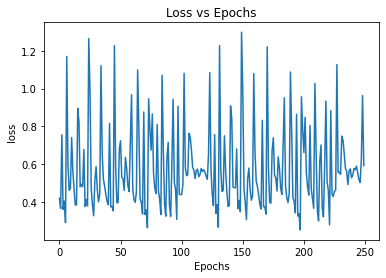

In [290]:
# plotting the loss

plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

In [291]:
# Remarks :
# Change size of Convolutional networks and change the layers
# Apply batch normalizing, etc..., cf Machine Learning course
# using a DataLoader ?
# Testing hyperparameters
# Printing accuracy at each time step ?
# Vérifier que les images training et test sont en couleur
# good link:  https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43